In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# ntuple file here
file = uproot.open('/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/close_by_double_pion/production/ntuples_10454408_0.root')

In [3]:
file.keys()
file.classnames()

{'ntuplizer': 'TDirectory',
 'ntuplizer/simtrackstersSC': 'TTree',
 'ntuplizer/simtrackstersCP': 'TTree',
 'ntuplizer/tracksters': 'TTree',
 'ntuplizer/clusters': 'TTree',
 'ntuplizer/graph': 'TTree',
 'ntuplizer/candidates': 'TTree',
 'ntuplizer/trackstersMerged': 'TTree',
 'ntuplizer/associations': 'TTree',
 'ntuplizer/tracks': 'TTree'}

In [4]:
trackstersclue3d = file["ntuplizer/tracksters"]
simtrackstersCP = file["ntuplizer/simtrackstersCP"]
graph = file["ntuplizer/graph"]
associations = file["ntuplizer/associations"]
candidates = file["ntuplizer/candidates"]
candidates.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
NCandidates          | unknown                  | <UnknownInterpretation 'non...
candidate_charge     | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
candidate_pdgId      | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
candidate_id_prob... | std::vector<std::vect... | AsObjects(AsVector(True, As...
candidate_time       | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
candidate_timeErr    | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
candidate_energy     | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
candidate_px         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
candidate_py         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
candidate_pz         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
track_in_candidate   | std::

In [5]:
# Get ntuples from tree in file
tracksterN = trackstersclue3d["NTracksters"].array(library='np')
x = trackstersclue3d["barycenter_x"].array(library='np')
y = trackstersclue3d["barycenter_y"].array(library='np')
z = trackstersclue3d["barycenter_z"].array(library='np')
linkedInners = graph["linked_inners"].array(library='np')
linkedOuters = graph["linked_outers"].array(library='np')
trackstersInCandidate = candidates["tracksters_in_candidate"].array(library='np')
simTracksters_CP_N = simtrackstersCP["stsCP_NTracksters"].array(library='np')
tsAssocMap = associations["tsCLUE3D_recoToSim_CP"].array(library='np')
tsAssocQual = associations["tsCLUE3D_recoToSim_CP_score"].array(library='np')

In [67]:
# Print ntuples
event_to_visualize = 200
print("N tracksters (CLU3D): ", tracksterN[event_to_visualize])
#print("trackster indices: ", indices[event_to_visualize])
print("", z[event_to_visualize])
#print(linkedInners[event_to_visualize])
#print(linkedOuters[event_to_visualize])
print("ts in candidate:   ", trackstersInCandidate[event_to_visualize])
print("ts Reco-Sim assoc: ", tsAssocMap[event_to_visualize])
print("assoc quality:     ", tsAssocQual[event_to_visualize])
print("N SimTrackster (from CP):", simTracksters_CP_N[event_to_visualize])

N tracksters (CLU3D):  36
 [351.42273 360.22522 362.2502  356.81592 359.04355 366.36862 370.38498
 366.39203 367.8289  368.3584  369.52335 374.1586  384.9298  395.5829
 374.73352 383.4358  383.84708 396.30078 404.8634  416.3179  421.26288
 415.23038 420.76816 429.49872 424.85657 430.92038 429.75458 457.6602
 446.90775 447.39368 479.0738  478.6989  484.71045 476.9277  496.8982
 493.9859 ]
ts in candidate:    [[0, 31, 9, 14, 32, 22], [1, 7, 17, 8, 29, 35, 5, 12, 20, 19, 25, 26], ..., [13, 30]]
ts Reco-Sim assoc:  [[1, 0], [0, 1], [1, 0], [1, 0], [1, 0], ..., [1, 0], [1, 0], [0, 1], [0, 1], [0, 1]]
assoc quality:      [[0.9998468, 5.1582805e-07], [1.0, 0.0], ..., [0.99997246, 1.3191555e-08]]
N SimTrackster (from CP): 2


In [68]:
# Truth graph
nodes_truth = []
edges_truth = []
ts_best_matches = []
assoc_threshold = 0.1
to_same = []

        
for i in range(tracksterN[event_to_visualize]):
    nodes_truth.append(i)
    #qualities = np.array(tsAssocQual[event_to_visualize][i])
    qualities = tsAssocQual[event_to_visualize][i]
    best_score = np.amin(qualities) #lowest score
    #assocmapnp = np.array(tsAssocMap[event_to_visualize][i])
    assocmapnp = tsAssocMap[event_to_visualize][i]
    best_score_sts = assocmapnp[np.argmin(qualities)] #sts with the lowest score
    if best_score < assoc_threshold:
        ts_best_matches.append([i, best_score_sts])
    else:
        ts_best_matches.append([i, -1])
        
        
for sts in range(simTracksters_CP_N[event_to_visualize]):
    to_same.append([])
print("Best matches [ts, sts]: ", ts_best_matches)
for ts, sts in ts_best_matches:
    to_same[sts].append(ts)
print("associated to_same:", to_same)

for ts_list in to_same:
    for idx, a in enumerate(ts_list):
        for b in ts_list[idx + 1:]:
            edges_truth.append([a,b])
#print("truth edges: ", edges_truth)            

Best matches [ts, sts]:  [[0, 0], [1, 1], [2, 0], [3, 0], [4, 0], [5, 1], [6, 1], [7, 1], [8, 1], [9, 0], [10, 1], [11, 1], [12, 1], [13, 1], [14, 0], [15, 1], [16, 1], [17, 1], [18, 1], [19, 1], [20, 1], [21, 1], [22, 0], [23, 1], [24, 1], [25, 1], [26, 1], [27, 1], [28, 1], [29, 1], [30, 1], [31, 0], [32, 0], [33, 1], [34, 1], [35, 1]]
associated to_same: [[0, 2, 3, 4, 9, 14, 22, 31, 32], [1, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35]]


In [78]:
# TICLGraph
edges = []
nodes = []
# pos in R-z, nx can't take 3D 
pos = {i:(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i]))) for i in range(tracksterN[event_to_visualize])}
for i in range(tracksterN[event_to_visualize]):
    nodes.append(i)
    #print(np.size(linkedInners[event_to_visualize][i]))
    for j in linkedInners[event_to_visualize][i]:
        edges.append([j,i])

# from TICLCandidates (linking)
edgesFromCandidate = []
NCandidates = 0
trackster_to_cand_map = [i for i in range(tracksterN[event_to_visualize])]
for i in trackstersInCandidate[event_to_visualize]:
    NCandidates+=1
    print(i)
    if np.size(i) <= 1:
        continue;
    else:
        for idx, j in enumerate(i):
            for k in i[idx+1:]:
                #print (j, k)
                edgesFromCandidate.append([j,k])
            trackster_to_cand_map[j] = NCandidates-1
#print("edges from candidate: ", edgesFromCandidate)
print("ts - cand map: ", trackster_to_cand_map)

[0, 31, 9, 14, 32, 22]
[1, 7, 17, 8, 29, 35, 5, 12, 20, 19, 25, 26]
[2]
[3]
[4]
[11, 23, 15, 18, 27, 10, 24, 33, 28]
[6, 21]
[16, 34]
[13, 30]
ts - cand map:  [0, 1, 2, 3, 4, 1, 6, 1, 1, 0, 5, 5, 1, 8, 0, 5, 7, 1, 5, 1, 1, 6, 0, 5, 5, 1, 1, 5, 5, 1, 8, 0, 0, 5, 7, 1]


In [70]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

TruthG = nx.Graph()
TruthG.add_nodes_from(nodes_truth)
TruthG.add_edges_from(edges_truth)

candidateG = nx.Graph()
candidateG.add_nodes_from(nodes)
candidateG.add_edges_from(edgesFromCandidate)

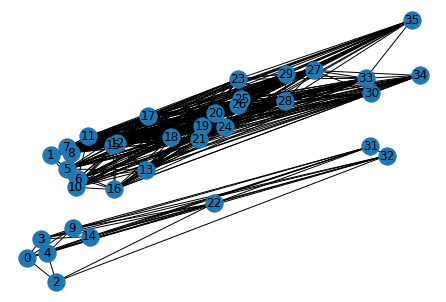

In [71]:
# TICLGraph
nx.draw(G, pos=pos, with_labels=True)

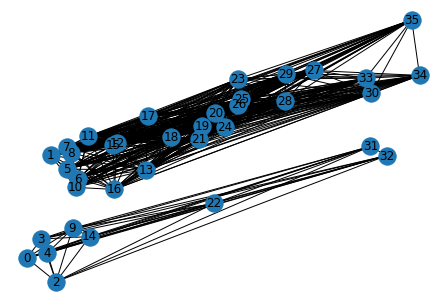

In [72]:
# Truth Graph
nx.draw(TruthG,pos=pos, with_labels=True)

In [73]:
# Graph from TICL Candidate (geometric linking)
#nx.draw(candidateG, with_labels=True)

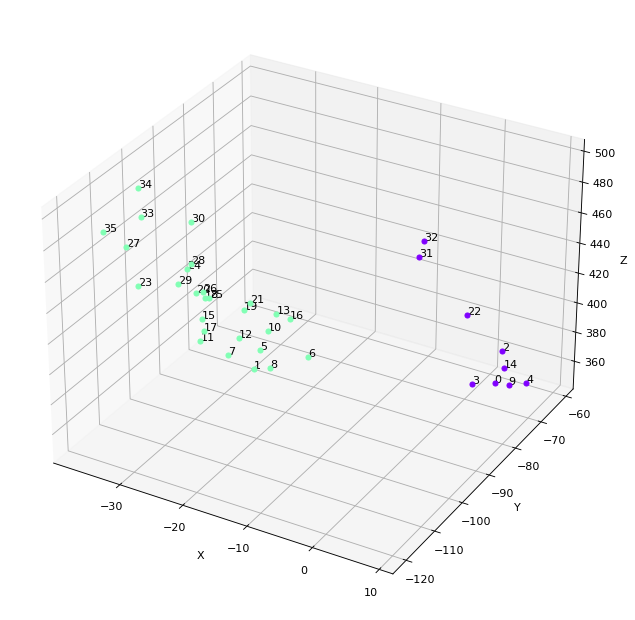

In [74]:
# CLUE3D Tracksters in 3D-cartesian coordinates
# colors represent ts->sts associations

fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=simTracksters_CP_N[event_to_visualize])

for i in range(tracksterN[event_to_visualize]):
    ax.scatter(x[event_to_visualize][i],y[event_to_visualize][i],z[event_to_visualize][i], color=cmap(norm(ts_best_matches[i])[1]))
    ax.text(x[event_to_visualize][i],y[event_to_visualize][i],z[event_to_visualize][i], '%s' % (str(i)), zorder=1, color='k')
plt.show()

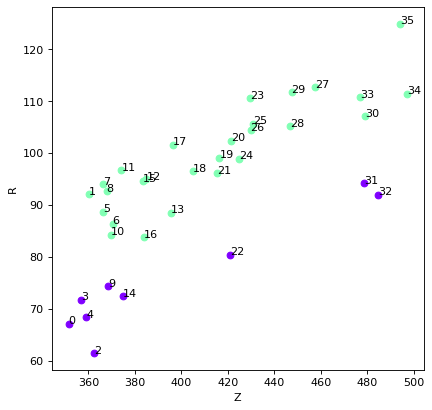

In [75]:
# in R-z, similar to the graph
# colors represent ts->sts associations

fig = plt.figure(figsize=(6,6), dpi=80)
ax = fig.add_subplot()
ax.set_xlabel('Z')
ax.set_ylabel('R')

for i in range(tracksterN[event_to_visualize]):
    ax.scatter(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), color=cmap(norm(ts_best_matches[i][1])))
    ax.text(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), '%s' %(str(i)), zorder=1, color='k')

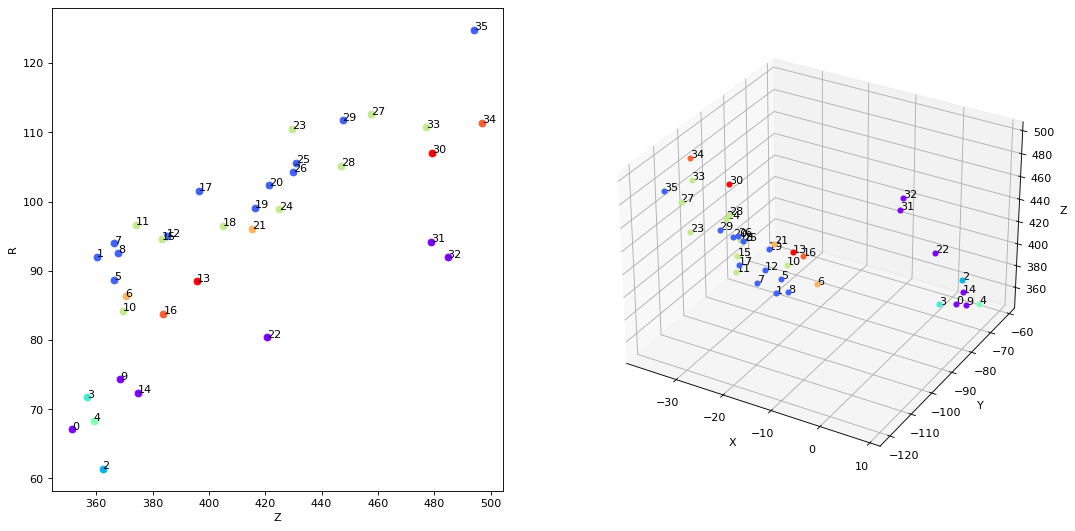

In [77]:
# in R-z, similar to the graph -> Geometric linking
# colors represent ts->sts associations

fig = plt.figure(figsize=(16,8), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Z')
ax.set_ylabel('R')
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=NCandidates-1)

for i in range(tracksterN[event_to_visualize]):
    ax.scatter(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), color=cmap(norm(trackster_to_cand_map[i])))
    ax.text(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), '%s' %(str(i)), zorder=1, color='k')
    
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for i in range(tracksterN[event_to_visualize]):
    ax.scatter(x[event_to_visualize][i], y[event_to_visualize][i], z[event_to_visualize][i], color=cmap(norm(trackster_to_cand_map[i])))
    ax.text(x[event_to_visualize][i], y[event_to_visualize][i], z[event_to_visualize][i], '%s' %(str(i)), zorder=1, color='k')